<a href="https://colab.research.google.com/github/KyungRyeolBaek/study/blob/main/tooth_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 틀

In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import datasets, layers, models

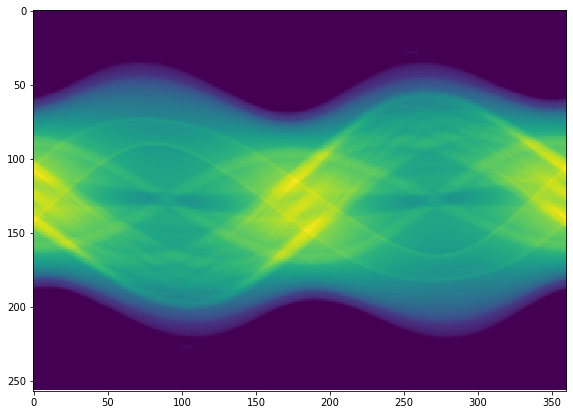

In [4]:
df = pd.read_table('./images/sino0.txt',sep='\t', header = None)
plt.figure(figsize = (15, 7))
plt.imshow(df.T)
plt.colorbar;

In [5]:
df.T.shape # 왜 256이 아니라 257이징?... train 과정에는 영향 없어서 pass

(257, 360)

훈련 데이터 :  

                가로 : 6개

                세로 : 총 6개 ( 120 위로 3개, 125 아래로 3개 )

                데이터 개수 : 360 - 6

                형태 : 354 * 6 * 6

In [6]:
pd.concat([df.iloc[0:6, 117:120], df.iloc[0:6, 125:128]], axis = 1).T

,0,1,2,3,4,5
117,231.0,230.0,232.0,231.0,232.0,235.0
118,229.0,229.0,228.0,231.0,230.0,231.0
119,233.0,231.0,229.0,228.0,230.0,229.0
125,250.0,248.0,251.0,251.0,249.0,245.0
126,249.0,249.0,248.0,250.0,251.0,249.0
127,245.0,248.0,248.0,247.0,250.0,249.0


예측 데이터 :  

                가로 : 1개 ( 훈련 데이터 가로 6개 중 (6/2)+1번째 -> 4번째 )

                세로 : 5개

                형태 : 5

In [7]:
pd.DataFrame(df.iloc[3, 120:125])

,3
120,231.0
121,236.0
122,241.0
123,244.0
124,249.0


데이터 형태.

train 344개, test 10개 -> 데이터 개수 많이 부족함.

수정 필요.

In [10]:
# train셋, test셋으로 나누어 줍니다. X는 입력 변수, y는 출력 변수
X_train_org, X_test_org, y_train_org, y_test_org = [], [], [], []

# X 형태 (6, 6), y 형태 (6)
for i in range(360 - 6):
  if i > 170 and i <= 180:
    X_test_org.append(pd.concat([df.iloc[0+i:6+i, 117:120], df.iloc[0+i:6+i, 125:128]], axis = 1))
    y_test_org.append(df.iloc[i+int(6/2), 120:125])
  else:
    X_train_org.append(pd.concat([df.iloc[0+i:6+i, 117:120], df.iloc[0+i:6+i, 125:128]], axis = 1))
    y_train_org.append(df.iloc[i+int(6/2), 120:125])

# np.array 형태로 변환 합니다.
X_train_org, X_test_org, y_train_org, y_test_org = np.array(X_train_org), np.array(X_test_org), np.array(y_train_org), np.array(y_test_org)

# RGB 값을 추가 합니다. 우선 흑백으로 설정 하였습니다.
# train 형태 : ((344, 6, 6, 1)), test 형태 : ((10, 6, 6, 1))
# tensorflow는 3차원만 지원하므로 3차원 형태로 reshape 해줘야 합니다.
X_train = X_train_org.reshape((344, 6, 6, 1))
X_test = X_test_org.reshape((10, 6, 6, 1))
y_train = y_train_org
y_test = y_test_org

# 픽셀 값을 0~1 사이로 정규화합니다.
X_train, X_test, y_train, y_test = X_train / 300.0, X_test / 300.0, y_train / 300.0, y_test / 300.0

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((344, 6, 6, 1), (10, 6, 6, 1), (344, 5), (10, 5))

모델 형태 만드는 부분.

데이터 형태(6, 6, 1)가 작다 보니 filter가 작아짐.

수정 필요.

이부분 수정에 따라 많이 결과가 바뀝니당 !

주석 처리 되어 있는 부분이 중간중간 지저분하게 있어서 읽고 나면 지우고 보시는게 깔끔해 보일겁니다 !

In [12]:
model = models.Sequential()
# Conv2D(feature, filter, activation, input_shape)
# feature 수만큼 그림을 만듦
# input_shape의 형태에서 filter 값의 -1 만큼 줄어든 상태로 output이 나옴
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(6, 6, 1)))
# MaxPooling2D(filter)
# filter안의 최대값을 추출해서 크기를 줄임. 저희는 안해도 될듯!
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((1, 1)))
# model.add(layers.Conv2D(64, (1, 1), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 4, 4, 32)          320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 35,589
Trainable params: 35,589
Non-trainable params: 0
_________________________________________________________________


모델 구성은 우선 adam, mse를 사용.

epoch 값 올리고 loss 부분도..

수정 필요

예측 결과 값을 어떻게 라벨링 해야 할지 고민해봐야 될 것 같습니다.

https://www.tensorflow.org/api_docs/python/tf/keras/losses

loss에 들어갈 수 있는 함수들 모은 사이트 입니다.

In [14]:
# model 구성
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

model.fit(X_test, y_test, epochs=5)

Epoch 1/5
1/1 [==============================] - 0s 976us/step - loss: 0.6041 - accuracy: 0.8000
Epoch 2/5
1/1 [==============================] - 0s 968us/step - loss: 0.5354 - accuracy: 0.8000
Epoch 3/5
1/1 [==============================] - 0s 2ms/step - loss: 0.4705 - accuracy: 0.8000
Epoch 4/5
1/1 [==============================] - 0s 1ms/step - loss: 0.4141 - accuracy: 0.8000
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 0.3551 - accuracy: 0.8000


In [15]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc

1/1 - 0s - loss: 0.3000 - accuracy: 0.8000


In [16]:
print(test_acc)   # 정확도

0.800000011920929


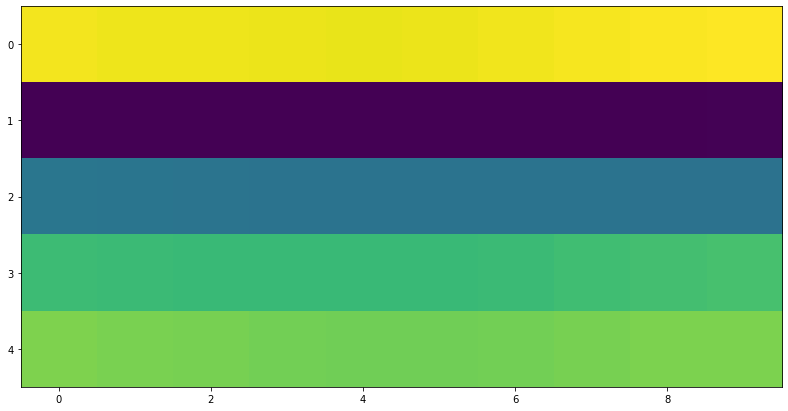

In [17]:
# 모델 예측
pred = model.predict(X_test)    # 예측 데이터를 ()안에 넣으면 됩니다.
plt.figure(figsize = (15, 7))
plt.imshow(pred.T)
plt.colorbar;

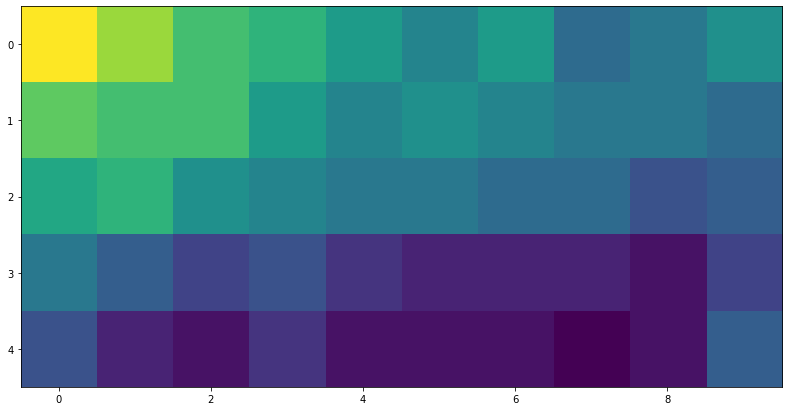

In [18]:
# 예측 결과 확인
plt.figure(figsize = (15, 7))
plt.imshow(y_test_org.T)        # 예측 결과 값을 () 안에 넣으면 됩니다.
plt.colorbar;

# 위에 수정 후 결과 좋으면 아래 진행 하겠습니다.

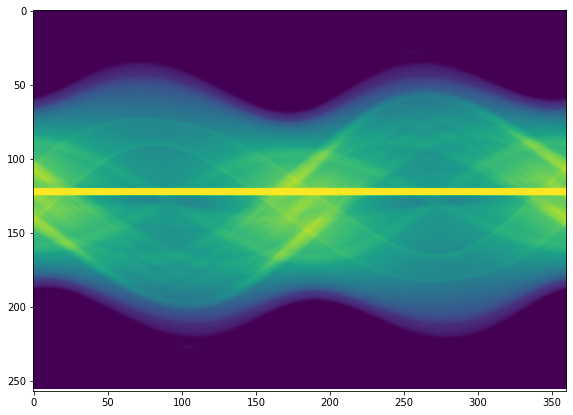

In [ ]:
df.iloc[:,120:125] = 300
plt.figure(figsize = (15, 7))
plt.imshow(df.T)
plt.colorbar;

In [ ]:
pd.concat([df.iloc[0:5, 117:120], df.iloc[0:5, 125:128]], axis = 1)

,117,118,119,125,126,127
0,231.0,229.0,233.0,250.0,249.0,245.0
1,230.0,229.0,231.0,248.0,249.0,248.0
2,232.0,228.0,229.0,251.0,248.0,248.0
3,231.0,231.0,228.0,251.0,250.0,247.0
4,232.0,230.0,230.0,249.0,251.0,250.0


In [ ]:
df.iloc[0:5, 120:125]

,120,121,122,123,124
0,300.0,300.0,300.0,300.0,300.0
1,300.0,300.0,300.0,300.0,300.0
2,300.0,300.0,300.0,300.0,300.0
3,300.0,300.0,300.0,300.0,300.0
4,300.0,300.0,300.0,300.0,300.0
